In [18]:
pip freeze > model_requirements.txt    

Note: you may need to restart the kernel to use updated packages.


In [19]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
data_train_df = pd.read_csv("data_train_csv")
data_smauto_train_df = pd.read_csv("data_smauto_train_csv")
data_smin_train_df = pd.read_csv("data_smin_train_csv")

data_test_df = pd.read_csv("data_test_csv")
data_val_df = pd.read_csv("data_val_csv")

In [21]:
print(f'Data_train: {data_train_df.shape}, Data smauto: {data_smauto_train_df.shape}, Data smin: {data_smin_train_df.shape}')

Data_train: (192638, 10), Data smauto: (293598, 10), Data smin: (288041, 10)


In [22]:
#own module which takes in df for train, test and val and returns in x and y format.  Can also sample.
from data_formatting import data_format

In [23]:
print(data_train_df['Winner_num'].value_counts())
print(data_smauto_train_df['Winner_num'].value_counts())
print(data_smin_train_df['Winner_num'].value_counts())

Winner_num
0    97866
2    92309
1     2463
Name: count, dtype: int64
Winner_num
0    97866
2    97866
1    97866
Name: count, dtype: int64
Winner_num
0    97866
1    97866
2    92309
Name: count, dtype: int64


Random Forest model

Train the baseline RF classifier

NOTE: Should I turn this into a function to call here and at the end?

In [24]:
#Original code

    rnd_clf = RandomForestClassifier(random_state=7)
    rnd_clf.fit(X_train, y_train)

    rnd_clf_train_score = rnd_clf.score(X_train, y_train)
    rnd_clf_test_score = rnd_clf.score(X_test, y_test)
    print("Training score:", rnd_clf_train_score)
    print("Testing score:", rnd_clf_test_score)

    y_pred_rf = rnd_clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_rf, labels=rnd_clf.classes_)
    cm_norm = confusion_matrix(y_test, y_pred_rf, labels=rnd_clf.classes_, normalize='true')
    cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['1', '2', '3'])

    cmd.plot()
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

    print(classification_report(y_test, y_pred_rf))

IndentationError: unexpected indent (3960503144.py, line 3)

In [25]:
def rf(train_data, test_data, val_data, sample, proportion):
    #own module which takes in df for train, test and val and returns in x and y format.  Can also sample.
    from data_formatting import data_format
    X_train, X_test, X_val, y_train, y_test, y_val = data_format(train_data, test_data, val_data, sample, proportion)

    rnd_clf = RandomForestClassifier(random_state=7)
    rnd_clf.fit(X_train, y_train)

    rnd_clf_train_score = rnd_clf.score(X_train, y_train)
    rnd_clf_test_score = rnd_clf.score(X_test, y_test)
    print(f"Training score: {rnd_clf_train_score}, Testing score: {rnd_clf_test_score}" )

    y_pred = rnd_clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=rnd_clf.classes_)
    cm_norm = confusion_matrix(y_test, y_pred, labels=rnd_clf.classes_, normalize='true')
    cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['0', '1', '2'])

    cmd.plot()
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

    print(classification_report(y_test, y_pred))

Training score: 0.9700007267517312
Testing score: 0.9265043298053438


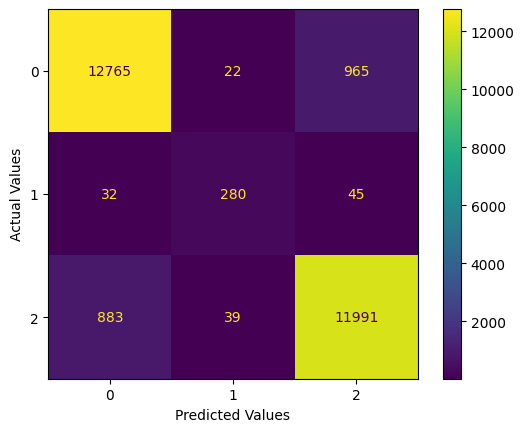

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     13752
           1       0.82      0.78      0.80       357
           2       0.92      0.93      0.93     12913

    accuracy                           0.93     27022
   macro avg       0.89      0.88      0.89     27022
weighted avg       0.93      0.93      0.93     27022



In [26]:
rf(data_train_df, data_test_df, data_val_df, None, None)

Training score: 0.9803098113747369
Testing score: 0.9293168529346458


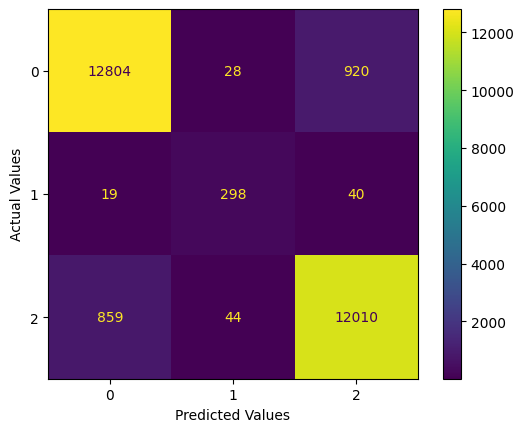

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     13752
           1       0.81      0.83      0.82       357
           2       0.93      0.93      0.93     12913

    accuracy                           0.93     27022
   macro avg       0.89      0.90      0.89     27022
weighted avg       0.93      0.93      0.93     27022



In [27]:
rf(data_smauto_train_df, data_test_df, data_val_df, None, None)

Training score: 0.9799334122572828
Testing score: 0.9297979424172896


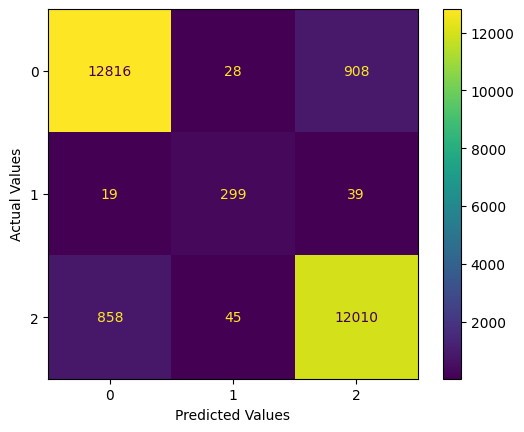

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     13752
           1       0.80      0.84      0.82       357
           2       0.93      0.93      0.93     12913

    accuracy                           0.93     27022
   macro avg       0.89      0.90      0.89     27022
weighted avg       0.93      0.93      0.93     27022



In [28]:
rf(data_smin_train_df, data_test_df, data_val_df, None, None)

Using min because recall is the more importantmetric in this case. Recall is the number of true positives/ true positives + False negatives.  I.e. out of the number of times it was actually positive, how many times did we predict it to be so.  Not as much of a concern for false negatives in category 1 because it has less impact than incorrectly giving the win to another team.

Tune the RF model

1 n_estimators, Train Accuracy: 0.9658416683735996, Validation Accuracy: 0.8964011471921547
6 n_estimators, Train Accuracy: 0.9787807985668707, Validation Accuracy: 0.9270052733832918
11 n_estimators, Train Accuracy: 0.9795515221791342, Validation Accuracy: 0.9296142103802387
16 n_estimators, Train Accuracy: 0.9797563541301412, Validation Accuracy: 0.9304653529466186
21 n_estimators, Train Accuracy: 0.9798257886898045, Validation Accuracy: 0.9310204459246924
26 n_estimators, Train Accuracy: 0.9798605059696363, Validation Accuracy: 0.9310204459246924
31 n_estimators, Train Accuracy: 0.9798882797935016, Validation Accuracy: 0.931242483115922
36 n_estimators, Train Accuracy: 0.979895223249468, Validation Accuracy: 0.9315940420020353
41 n_estimators, Train Accuracy: 0.9799056384334175, Validation Accuracy: 0.9315015265056897
46 n_estimators, Train Accuracy: 0.979916053617367, Validation Accuracy: 0.9315755389027662
51 n_estimators, Train Accuracy: 0.9799195253453501, Validation Accuracy: 0

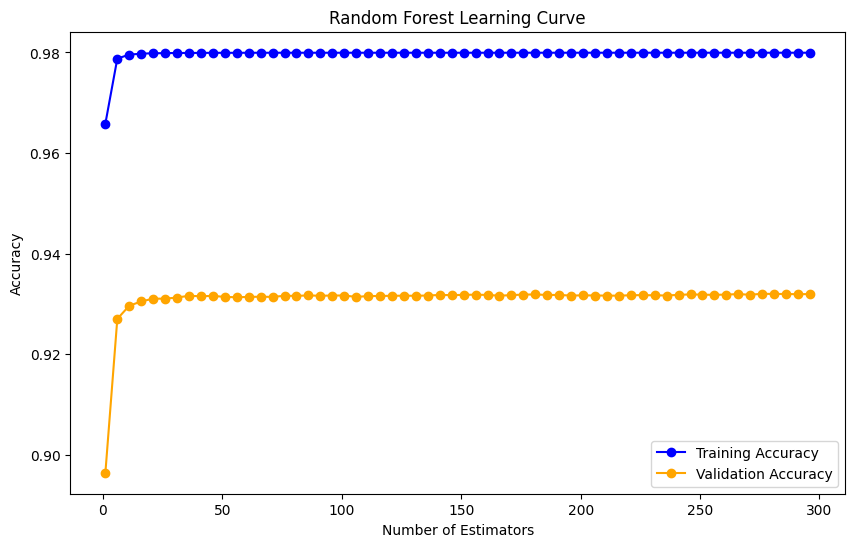

In [40]:
best_accuracy = 0
estimators = []
train_acc_list = []
val_acc_list = []
for e in range(1,300, 5):
    estimators.append(e)

    model = RandomForestClassifier(n_estimators=e, n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    print(f"{e} n_estimators, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

    if val_accuracy> best_accuracy:
        best_accuracy = accuracy
        best_estimators = e
    
estimators_df = pd.DataFrame({'Estimators': estimators,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})

print(f"Best accuracy is: {best_accuracy} and estimators is {best_estimators}")

plt.figure(figsize=(10, 6))
plt.title('Random Forest Learning Curve')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.plot(estimators_df['Estimators'], estimators_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(estimators_df['Estimators'], estimators_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.legend()
plt.show()

In [29]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30, 40 ,50, 60, 70, 80, 90, 100],
    'max_features': [1, 2, 3, 4, 5, 6, 7, 8],
    'min_sample_split': [10, 50, 100, 200],
    'max_terminal_nodes': [0, 5, 10, 50, 100],
    'min_samples_leaf': [1, 100, 200, 300, 400, 500],
    'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9],
    }

In [31]:
X_train, X_test, X_val, y_train, y_test, y_val = data_format(data_smin_train_df, data_test_df, data_val_df, None, None)

10 max depth, Train Accuracy: 0.8493478358983617, Validation Accuracy: 0.7758719585530577
20 max depth, Train Accuracy: 0.9767845549765485, Validation Accuracy: 0.9394393560921455
30 max depth, Train Accuracy: 0.9798882797935016, Validation Accuracy: 0.9319085946896105
40 max depth, Train Accuracy: 0.979916053617367, Validation Accuracy: 0.9316125451013044
50 max depth, Train Accuracy: 0.979916053617367, Validation Accuracy: 0.9314275141086132
Best accuracy is: 0.9314460172078823 and estimators is 40


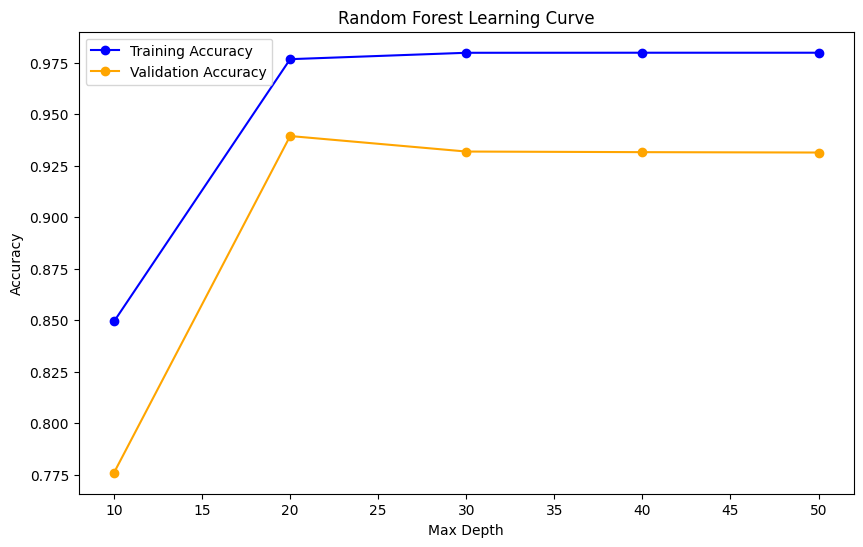

In [41]:
best_accuracy = 0
depth_list = []
train_acc_list = []
val_acc_list = []
for md in param_grid['max_depth']:
    depth_list.append(md)

    model = RandomForestClassifier(n_estimators=50, max_depth=md, n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    print(f"{md} max depth, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

    if val_accuracy> best_accuracy:
        best_accuracy = accuracy
        best_depth= md
    
depth_df = pd.DataFrame({'Max Depth': depth_list,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})

plt.figure(figsize=(10, 6))
plt.title('Random Forest Learning Curve')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.plot(depth_df['Max Depth'], depth_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(depth_df['Max Depth'], depth_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.legend()
plt.show()

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20 30, 40 ,50, 60, 70, 80, 90, 100],
    'max_features': [1, 2, 3, 4, 5, 6, 7, 8],
    'min_sample_split': [10, 50, 100, 200],
    'max_terminal_nodes': [0, 5, 10, 50, 100],
    'min_samples_leaf': [1, 100, 200, 300, 400, 500],
    'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9],
    }

15 max depth, Train Accuracy: 0.945705646071219, Validation Accuracy: 0.9097048755666575
16 max depth, Train Accuracy: 0.9563187185157669, Validation Accuracy: 0.9234526783236192
17 max depth, Train Accuracy: 0.964248145229325, Validation Accuracy: 0.9320196132852253
18 max depth, Train Accuracy: 0.9705979357105412, Validation Accuracy: 0.938366176334536
19 max depth, Train Accuracy: 0.9746702726347986, Validation Accuracy: 0.9406420575446387
20 max depth, Train Accuracy: 0.9767845549765485, Validation Accuracy: 0.9394393560921455
21 max depth, Train Accuracy: 0.9782426807294795, Validation Accuracy: 0.9378110833564622
22 max depth, Train Accuracy: 0.9789196676861974, Validation Accuracy: 0.9363493385142011
23 max depth, Train Accuracy: 0.9792841991244302, Validation Accuracy: 0.9352391525580535
24 max depth, Train Accuracy: 0.9795306918112352, Validation Accuracy: 0.9341844758997132
Best accuracy is: 0.9314460172078823 and estimators is 24


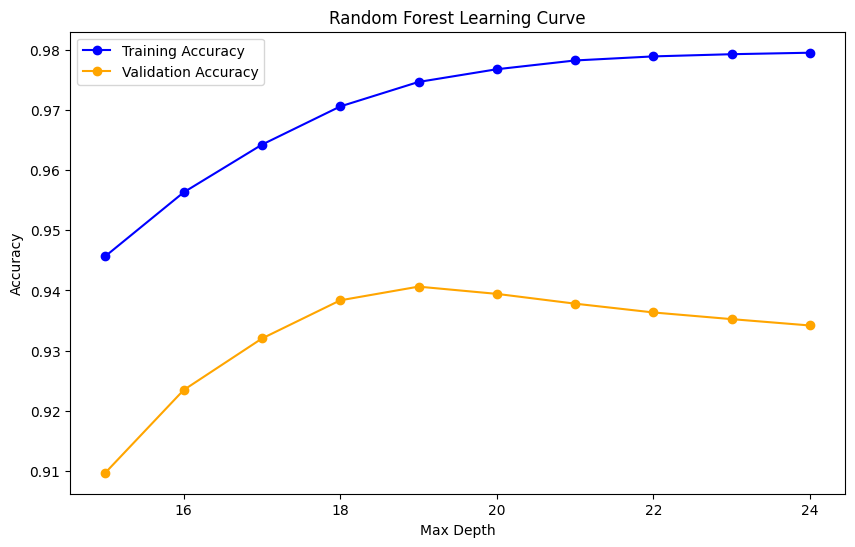

In [42]:
best_accuracy = 0
depth_list = []
train_acc_list = []
val_acc_list = []
for md in range(15, 25):
    depth_list.append(md)

    model = RandomForestClassifier(n_estimators=50, max_depth=md, n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    print(f"{md} max depth, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

    if val_accuracy> best_accuracy:
        best_accuracy = accuracy
        best_depth= md
    
depth_df = pd.DataFrame({'Max Depth': depth_list,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})

plt.figure(figsize=(10, 6))
plt.title('Random Forest Learning Curve')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.plot(depth_df['Max Depth'], depth_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(depth_df['Max Depth'], depth_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.legend()
plt.show()

In [34]:
estimators

[50, 100, 150, 200]

https://github.com/ngoix/scikit-learn/commit/2661da0d3578eda406dcf1867443d9f744165c5f

Accuracy for 1 max_depth is:0.6840410768803774
Accuracy for 2 max_depth is:0.6628180220186881
Accuracy for 3 max_depth is:0.6460727171801277
Accuracy for 4 max_depth is:0.637709316310482
Accuracy for 5 max_depth is:0.6534184475899714
Accuracy for 6 max_depth is:0.6702377648256083
Accuracy for 7 max_depth is:0.6965306688870386
Accuracy for 8 max_depth is:0.7262466463132574
Accuracy for 9 max_depth is:0.7529836247571469
Accuracy for 10 max_depth is:0.7790729947266167
Accuracy for 11 max_depth is:0.8098436488111759
Accuracy for 12 max_depth is:0.8400962161161994
Accuracy for 13 max_depth is:0.8641317420667962
Accuracy for 14 max_depth is:0.888759367194005
Accuracy for 15 max_depth is:0.9100379313535018
Accuracy for 16 max_depth is:0.924877416967342
Accuracy for 17 max_depth is:0.9336293829216393
Accuracy for 18 max_depth is:0.9385142011286891
Accuracy for 19 max_depth is:0.9401239707651031
Accuracy for 20 max_depth is:0.9392728281987233
Accuracy for 21 max_depth is:0.9379035988528078
Accu

<Axes: xlabel='Depth'>

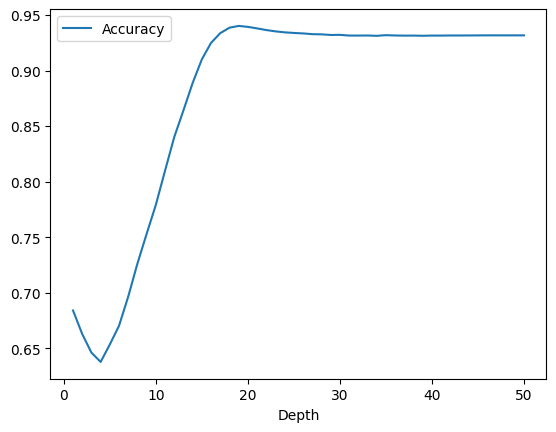

Use the tuned hyperparameters for a new RF

1st - Manually tuned using a validation set

In [ ]:
rnd_clf_tweaked_man = RandomForestClassifier(n_estimators=100, max_depth=19, n_jobs=-1, random_state=7)
rnd_clf_tweaked_man.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_jobs=-1, random_state=7)

In [ ]:
rnd_clf_tweaked_man_train_score = rnd_clf_tweaked_man.score(X_train, y_train)
rnd_clf_tweaked_man_test_score = rnd_clf_tweaked_man.score(X_test, y_test)
print("Training score:", rnd_clf_tweaked_man_train_score)
print("Testing score:", rnd_clf_tweaked_man_test_score )

Training score: 0.9746529139948826
Testing score: 0.9364961882910221


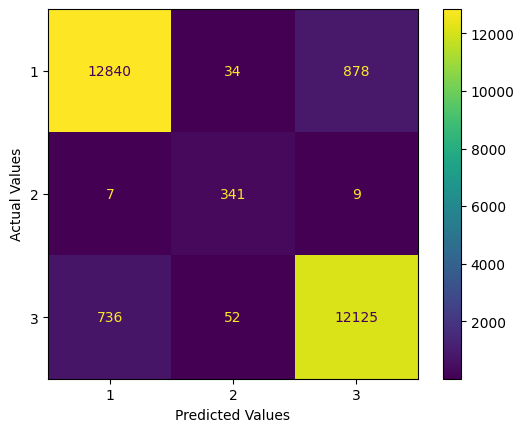

In [ ]:
y_tweaked_man_pred_rf = rnd_clf_tweaked_man.predict(X_test)

cm = confusion_matrix(y_test, y_tweaked_man_pred_rf, labels=rnd_clf_tweaked_man.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['1', '2', '3'])
cmd.plot()
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

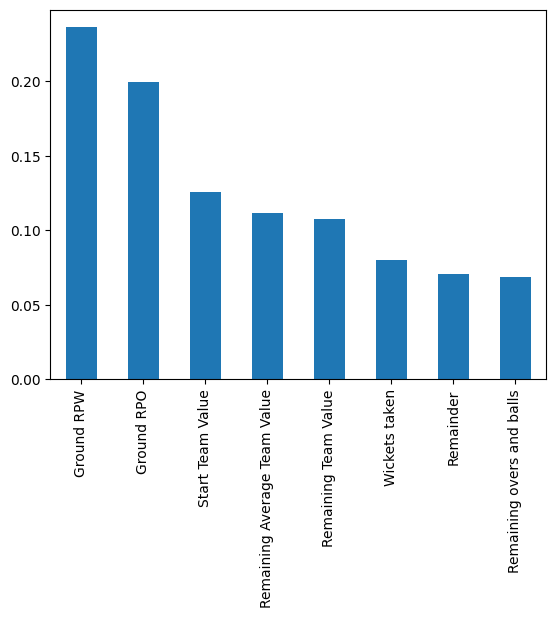

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rnd_clf_tweaked_man.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

In [ ]:
sdfsdf

NameError: name 'sdfsdf' is not defined

2nd - Tweak with CV version

In [ ]:
rnd_clf_tweaked_CV = RandomForestClassifier(n_estimators=100, max_depth=19, n_jobs=-1, random_state=7)
rnd_clf_tweaked_CV.fit(X_train, y_train)

In [ ]:
rnd_clf_tweaked_CV_train_score = rnd_clf_tweaked_CV.score(X_train, y_train)
rnd_clf_tweaked_CV_test_score = rnd_clf_tweaked_CV.score(X_test, y_test)
print("Training score:", rnd_clf_tweaked_CV_train_score)
print("Testing score:", rnd_clf_tweaked_CV_test_score )

In [ ]:
y_tweaked_CV_pred_rf = rnd_clf_tweaked_CV.predict(X_test)

cm = confusion_matrix(y_test, y_tweaked_CV_pred_rf, labels=rnd_clf_tweaked_CV.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['1', '2', '3'])
cmd.plot()
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rnd_clf_tweaked_CV.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

https://www.datacamp.com/tutorial/random-forests-classifier-python